## **# Univariate, Multivariate, Single Step, Multi Step LSTM Time series forecasting 실습 예제** 


(1)forecast a univariate time series
(2)multivariate time series.

In [52]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Thw weather dataseet**

14개의 기온, 기압, 습도 등의 기후 데이터를 포함하고 있으며 2003년부터 매 10분마다 적재되었음. **실습에서는 09~16년도 만 사용하도록 해요 

In [53]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [54]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [55]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [56]:
df.shape

(420551, 15)

*매 10분마다 측정해서 1시간에 6개의 observation이 있으며 하루에 144개의 데이터가 있음

특정시점에서 6시간뒤의 온도를 예측하는 모형을 생성 5일간의 데이터를 사용-> 1445 = 720개의 데이터를 사용하여 학습.

*'history_size'는 과거의 정보 'target_size'는 얼마나 먼 미래를 예측하고 싶은지 우리가 원하는예측값의 사이즈

# def univariate_data(dataset, start_index, end_index, history_size, target_size)
미리 예측대상을 함수로 정의하여 추후에  dataset만 바꾸면 쉽게 이용할 수 있도록 한다
- dataseet: 예측대상용 원본 데이터셋
- start_index: 예측시작 row
- end_idnex: 예측 종료 rlw
- history_size:과거의 자료를 얼마만큼 사용할 건지
- target_size: 얼마나 먼 미래를 예측할 것인지

return np.array(data), np.array(labels)
- np.array(data) 행
- np.array(labels) 열

In [57]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

# *학습데이터: 300,000 rows(~2100일) 나머지는 확인 데이터 ***굵은 텍스트***

In [58]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [59]:
tf.random.set_seed(13)

# **Part 1: Forecast a univariate time series**

*self데이터만을 사용해서 예측.

In [60]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e013a14d0>],
      dtype=object)

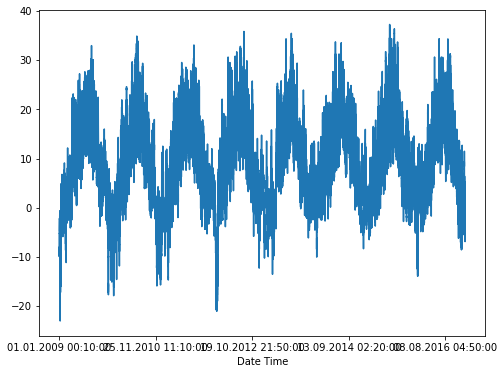

In [61]:
uni_data.plot(subplots=True)

In [62]:
uni_data = uni_data.values

**스캐일링하는것은 매우 중요. Standardization은 mean값을 뺸 뒤 std으로 내누는 방식을 택함 (가장 보편적) tf.keras.utils.normalize을 사용해서 [0,1]사이의 값으로 스케일링 .

Note: The mean and standard deviation should only be computed using the training data.

uni_data[:TRAIN_SPLIT].mean() : 평균
uni_data[:TRAIN_SPLIT].std() : 표준편차

In [63]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data.

In [64]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

**최근 20개 값을 골라서, 하나의 값을 추출해 낼 거다**

앞에서 정의한 univariate_data 함수를 호출

x_train_uni, y_train_uni = univariate_data(uni_data, 0, 300000,20, 10)

x_val_uni, y_val_uni = univariate_data(uni_data, 300000,None, 20, 0)

In [65]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the univariate_data function returns.

In [66]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


*데이터가 생성완료 하나의 예시 (주어진 정보는 blue, red 의 정보를 예측해야함)

# 시작적으로 데이터를 확인하는 방법

In [67]:
def create_time_steps(length):
  return list(range(-length, 0))

# **show_plot(plot_data, delta, title) 보여주는 함수 미리 정의!**

In [68]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

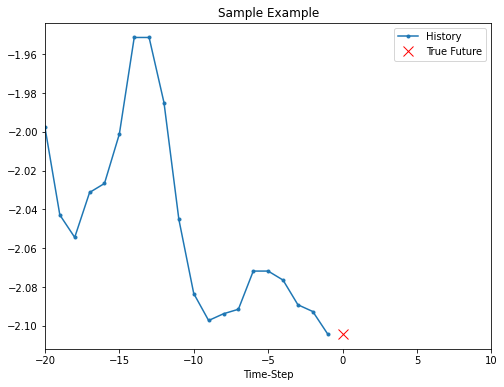

In [69]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

# **Baseline**

베이스라인 --> 과거 20개의 observation의 평균을 예측값으로 설정

In [70]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

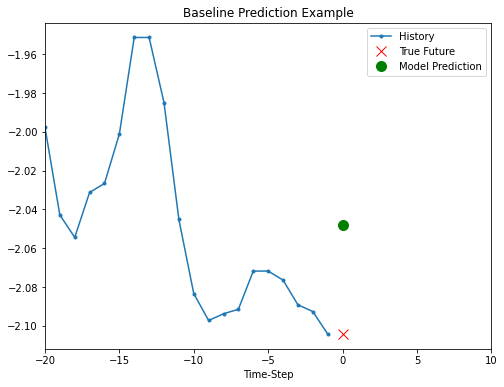

In [71]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

# **ecurrent neural network (LSTM)**

tf.data를 통해 셔플링, 배치화 등을 할 수 있음

이거는 크게 변경할 필요가 없다!!!

BATCH_SIZE: 전체 데이터 중 256개를 샘플링하겠다

univariate: univariate(단일 input변수) 분석을 하겠다

In [72]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

**LSTM모형 정의**

LSTM모형의 아주 복잡한 수식들을 미리 다 정의해놓았다

tensorflow를 이용하여 lstm모형을 만들고, 

korea 모형을 써서 분석을 하겠다!


In [73]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

샘플을 만들어서 체크해보기

In [74]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


**학습 과정 --> 메모리/시간상 각 epoch에 200번의 step만

200번을 학습할 건데(EVALUATION_INTERVAL)

10번을 반복할 거야(EPOCHS)

In [75]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0287 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0263 - val_loss: 0.0200
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0174

**Predict using the simple LSTM **

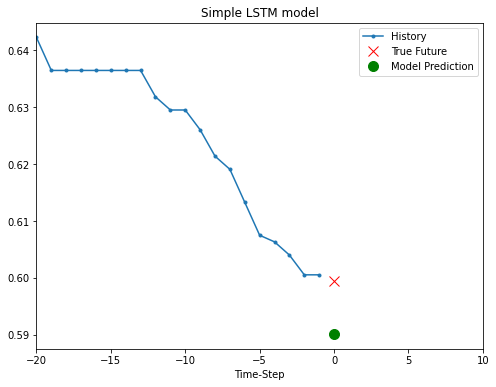

In [76]:
for x, y in val_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

**베이스라인보다 좋아보임!

# **Part 2: Forecast a multivariate time series**

원 데이터에는 14개의 feature가 포함되어있으나 예제에서는 3개만 포함. (온도, 기압, air density)

In [77]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [78]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


**각각의 feature의 raw data 확인 **

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d7cbec310>,
      dtype=object)

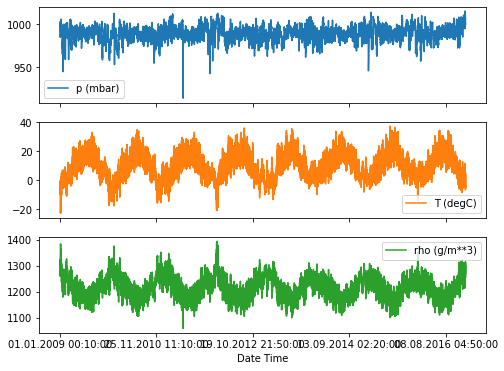

In [79]:
features.plot(subplots=True)

데이터에 처음 해야할 일은 언제나 Standardization!!

In [80]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [81]:
dataset = (dataset-data_mean)/data_std

**Single step model**


Single Step에서는 과거를 통해 한개의 포인트를 예측
위의 예제와 같은 윈도우를 취함.

미리 함수를 정의

In [82]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

네트워크는 지난 5일 (720개의 값) 의 데이터가 매 시간 측정됨. 이 예제에서는 1시간동안 큰 변화가 없다는 가정하에 시간당의 샘플링을 취함. 따라서 지난 720개가 아닌 120개의 데이터가 지난 5일간의 과거를 표현. Single Step Prediction a모형에서는 12시간 뒤의 데이터포인트였으나 이번에는 72개 뒤의 값을 책정 (12*6)

In [83]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.

In [84]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [85]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [86]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                4608      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


Let's check out a sample prediction.

In [87]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [88]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 12ms/step - loss: 0.3090 - val_loss: 0.2646
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2623 - val_loss: 0.2431
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2613 - val_loss: 0.2474
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2567 - val_loss: 0.2447
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2262 - val_loss: 0.2356
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2413 - val_loss: 0.2680
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2403 - val_loss: 0.2533
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2392 - val_loss: 0.2385
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2448 - val_loss: 0.2459
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.2379 - val_loss: 0.2

loss값과 val_loss값(오차값)이 함께 떨어지는 것이 예측모델의 정확도가 높다.

떨어지지 않을 경우 예측 모델의 정학도가 떨어진다. (다시 예측하라!) **굵은 텍스트**

In [89]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

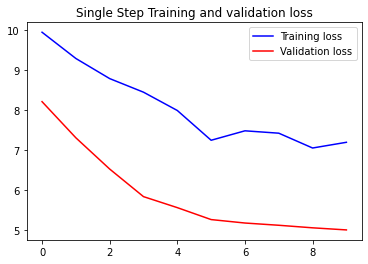

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

**Predict a single step future**

모형이 학습이되었으니 예측값을 생성해보자. 
3개의 feature의 5일간의 시간당 과거값을 사용 (120개의 데이터들)하여 온도값을 예측. 
예측값은 하루뒤의 값을 예측하도록 설정 

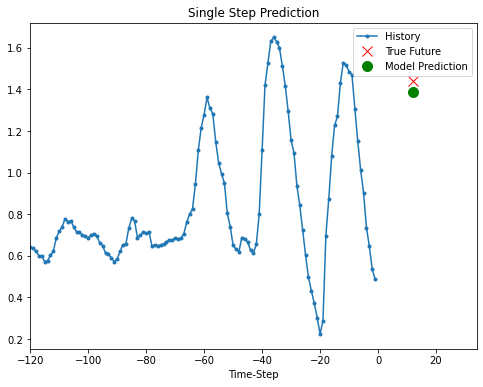

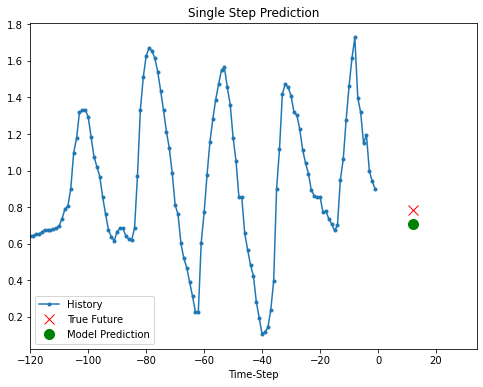

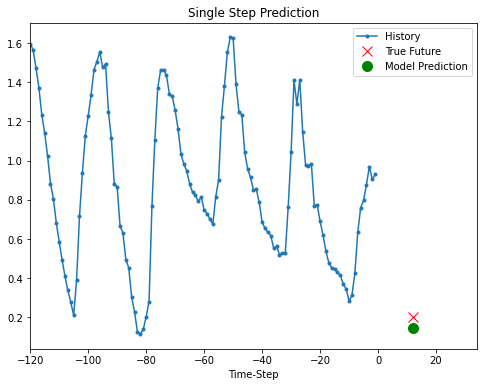

In [90]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# **Multi-Step model**

멀티스텝 모형에서는 과거가 주어졌을때 미래 값의 Range를 예측하도록 설정. (Sequence를 예측)

멀티스텝모형에서 역시 학습 데이터는 과거 5일간의 시간당 샘플된 데이터를 사용. 이 모형에서는 다음 12시간동안의 온도를 예측 (매 10분마다 측정된 값이므로 72개의 예측값을 뱉어내야 함)

In [91]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

샘플 엿보기

In [92]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [93]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [94]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [95]:
# This is formatted as code

플랏을 그릴때는 과거와 미래값은 시간당 데이터로 표현

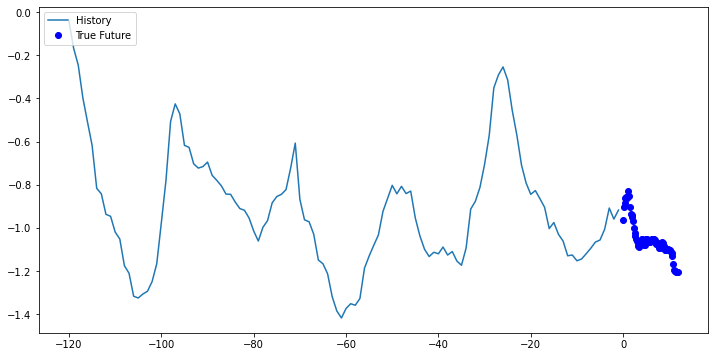

In [96]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

조금 더 복잡한 모형이라 두개의 LSTM레이어를 쌓도록 함. Dense Layer는 72개의 아웃풋을 생성

In [97]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 120, 32)           4608      
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 72)                1224      
                                                                 
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


Let's see how the model predicts before it trains.

In [98]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [99]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 45s 215ms/step - loss: 0.4953 - val_loss: 0.3059
Epoch 2/10
200/200 [==============================] - 42s 209ms/step - loss: 0.3464 - val_loss: 0.2834
Epoch 3/10
200/200 [==============================] - 44s 220ms/step - loss: 0.3247 - val_loss: 0.2503
Epoch 4/10
200/200 [==============================] - 43s 213ms/step - loss: 0.2412 - val_loss: 0.2165
Epoch 5/10
200/200 [==============================] - 42s 212ms/step - loss: 0.1989 - val_loss: 0.2000
Epoch 6/10
200/200 [==============================] - 42s 210ms/step - loss: 0.2074 - val_loss: 0.2089
Epoch 7/10
200/200 [==============================] - 42s 209ms/step - loss: 0.1971 - val_loss: 0.2019
Epoch 8/10
200/200 [==============================] - 42s 210ms/step - loss: 0.1948 - val_loss: 0.1970
Epoch 9/10
200/200 [==============================] - 41s 207ms/step - loss: 0.1964 - val_loss: 0.1974
Epoch 10/10
200/200 [==============================] - 42s 210ms/step - l

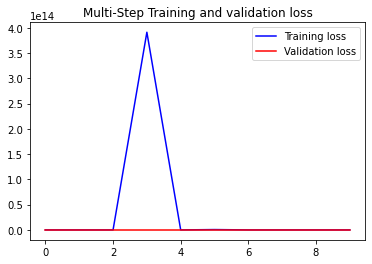

In [50]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

**Predict a multi-step future**

Let's now have a look at how well your network has learnt to predict the future.

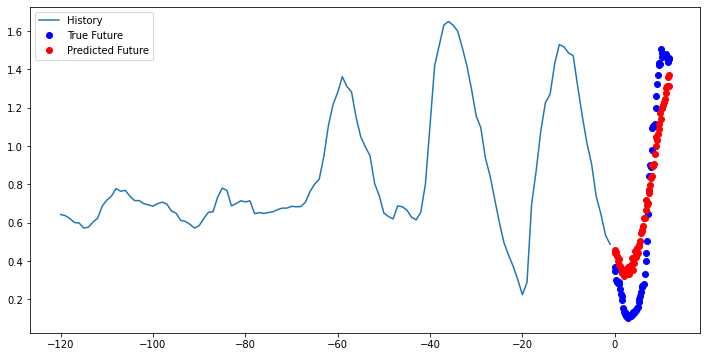

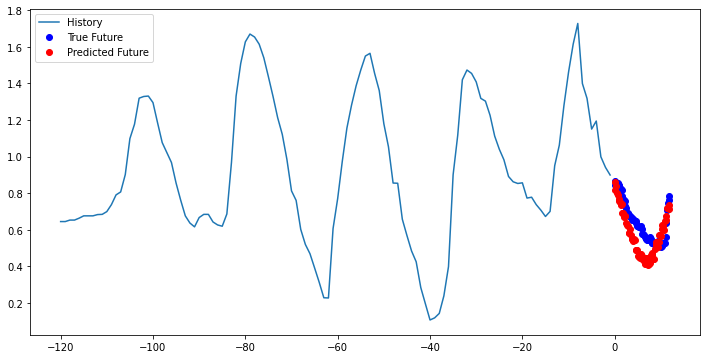

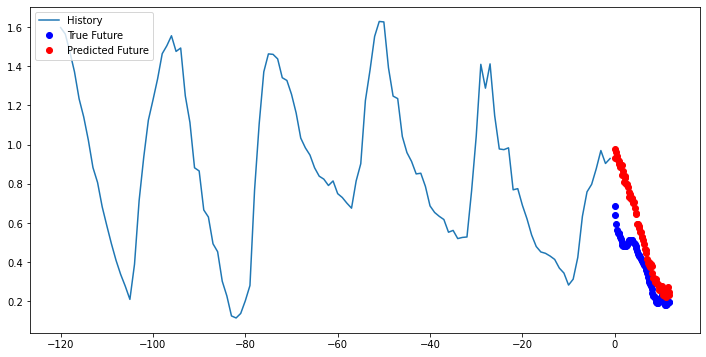

In [100]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])